In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Код Baseline

In [53]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [54]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Подготовка и Очистка данных

In [55]:
#Ячейка для подгрузки в Kaggle
'''# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/data_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'data_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн'''

"# Подгрузим наши данные из соревнования\n\nDATA_DIR = '/kaggle/input/sf-booking/'\ndf_train = pd.read_csv(DATA_DIR+'/data_train.csv') # датасет для обучения\ndf_test = pd.read_csv(DATA_DIR+'data_test.csv') # датасет для предсказания\nsample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн"

In [56]:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн'''

#### Удаление дубликатов

In [57]:
print(df_train.duplicated().value_counts())
print(df_test.duplicated().value_counts())

False    386496
True        307
dtype: int64
False    128906
True         29
dtype: int64


Оба датасета содержат дубликаты, но мы можем почистить только train, чтобы не сломать submission на финальном этапе

In [58]:
df_train.drop_duplicates(inplace=True)

In [59]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train.drop_duplicates(), sort=False).reset_index(drop=True) # объединяем

C:\Users\vlad\AppData\Local\Temp\ipykernel_15188\835644699.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train.drop_duplicates(), sort=False).reset_index(drop=True) # объединяем


#### Работа с пропусками

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Из .info() было видно, что данные практически без пропусков. Наличие одинакового числа пропусков только в lat и lng c чем-то связано. Вероятно с недоступностью координат для конкретных отелей.

In [61]:
# Код для получения датафрейма из строчек, содержащих nan
def get_nan_rows(df1):
    def get_not_nan(df):
        for col in df.columns:
            df = df[~pd.isnull(df[col])]
        return df
    df2 = get_not_nan(df1)
    return df1[~df1.apply(tuple,1).isin(df2.apply(tuple,1))]

nan_df = get_nan_rows(data)

In [62]:
# Проверяем, есть ли для в датафрейме другие строчки этих отелей (содержащие координаты). True - значит нет таких.
nan_df['hotel_name'].shape[0] == data[data['hotel_name'].isin(nan_df['hotel_name'].values)].shape[0]

True

In [63]:
# Вариант решения с подстановкой координат центров городов. Забраковали на вебинаре
'''# Таких строчек не нашлось, будем подставлять данные. Пусть это будут данные центров городов из интернета. (Дальнейший анализ показывал, что координаты не так уж важны, так что сильно не заморачиваемся)
hotels['city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2])
nan_df = get_nan_rows(hotels)
print(nan_df['city'].value_counts())

info = {'Vienna':(48.210033, 16.363449), 'Paris':(48.864716, 2.349014), 'Barcelona':(41.390205, 2.154007)}
# Заполняем координаты в nan_df
nan_df.lat = nan_df.city.apply(lambda x: info[x][0])
nan_df.lng = nan_df.city.apply(lambda x: info[x][1])

#Делаем из nan_df словари{название:координата} и заполненяем значения в основном датафрейме 
info = dict(zip(nan_df.hotel_name, nan_df.lat))
hotels.lat = hotels.lat.fillna(hotels.hotel_name.map(info))
info = dict(zip(nan_df.hotel_name, nan_df.lng))
hotels.lng = data.lng.fillna(hotels.hotel_name.map(info))
hotels.info()'''

"# Таких строчек не нашлось, будем подставлять данные. Пусть это будут данные центров городов из интернета. (Дальнейший анализ показывал, что координаты не так уж важны, так что сильно не заморачиваемся)\nhotels['city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-5] if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-2])\nnan_df = get_nan_rows(hotels)\nprint(nan_df['city'].value_counts())\n\ninfo = {'Vienna':(48.210033, 16.363449), 'Paris':(48.864716, 2.349014), 'Barcelona':(41.390205, 2.154007)}\n# Заполняем координаты в nan_df\nnan_df.lat = nan_df.city.apply(lambda x: info[x][0])\nnan_df.lng = nan_df.city.apply(lambda x: info[x][1])\n\n#Делаем из nan_df словари{название:координата} и заполненяем значения в основном датафрейме \ninfo = dict(zip(nan_df.hotel_name, nan_df.lat))\nhotels.lat = hotels.lat.fillna(hotels.hotel_name.map(info))\ninfo = dict(zip(nan_df.hotel_name, nan_df.lng))\nhotels.lng = data.lng.fillna(hotels.hotel_name.map(info))\nhotels.info()"

In [64]:
# Ниже код для библиотеки geopy. Не работает с этими адресами. Может потому и нет координат в базе? В адресах отелей явно есть пропущенные редкие буквы алфавита соответсвующих языков.
'''%pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="PavlovVS")
nan_df['lat'] = nan_df['hotel_address'].apply(lambda x: geolocator.geocode(x).latitude)
nan_df['lng'] = nan_df['hotel_address'].apply(lambda x: geolocator.geocode(x).longitude)
nan_df['hotel_address'].value_counts()'''

'%pip install geopy\nfrom geopy.geocoders import Nominatim\ngeolocator = Nominatim(user_agent="PavlovVS")\nnan_df[\'lat\'] = nan_df[\'hotel_address\'].apply(lambda x: geolocator.geocode(x).latitude)\nnan_df[\'lng\'] = nan_df[\'hotel_address\'].apply(lambda x: geolocator.geocode(x).longitude)\nnan_df[\'hotel_address\'].value_counts()'

In [65]:
# Очень много времени отнял этот шаг. Скопирую решение @Andrew VolkovA2
# https://www.kaggle.com/code/andrewvolkova2/andrew-volkov-sf-dst-booking-reviews
# Сгрупируем по отелям и посмотрим у каких отелей отсутствуют геоданные
hotels_with_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
hotels_with_coor.head(2)

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55


In [66]:
# 17 отелей
hotels_with_coor[['lat','lng']] = 0
hotels_with_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
hotels_with_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
hotels_with_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
hotels_with_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
hotels_with_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
hotels_with_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
hotels_with_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
hotels_with_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
hotels_with_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
hotels_with_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
hotels_with_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
hotels_with_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
hotels_with_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
hotels_with_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
hotels_with_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
hotels_with_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
hotels_with_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']

# Так как адрес у нас носит уникальный характер (я это соответственно проверил), а название отелей
# есть повторяющиеся, то установим адрес как индекс, для последующего применения метода map
hotels_with_coor.set_index('hotel_address', inplace=True)

hotels_with_coor.head(2)

,hotel_name,additional_number_of_scoring,lat,lng
hotel_address,,,,
20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37,48.8399957,2.3070823
23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55,48.8889127,2.3309643


In [67]:
# Напишем небольшую функцию, для заполнения пропусков в геоданных
def add_missing_coors(address, data_dict):
  """
  Входной параметр адрес, используется для поиска lng, lat в поданном вторым аргументов dataframe.
  Адрес в dataframe является индеком

  Args:
      address (str): строка с адресом отеля
      data_dict (pd.Dataframe()): Dataframe с lng, lat в качестве признаков и адресом в качестве индекса

  Returns:
      pd.Series(): возвращает lng, ltd
  """
  if address in data_dict.index:
    return pd.Series([data_dict.loc[address].lat, data_dict.loc[address].lng],
                     index = ['lat','lng'])

In [68]:
# Работаем только с записями, у которых в наличие пропуски по геоданным, и заполняем пропуски данными в 
# соотвествии с указанными выше геокоординатами
data.loc[data[(data.lat.isna() | data.lng.isna())].index,['lat','lng']] = \
data[data.lat.isna() | data.lng.isna()].loc[:].\
  apply(lambda x: add_missing_coors(x.hotel_address, hotels_with_coor), axis = 1)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

#### Оценка выбросов

In [70]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,0.74985,6.296715
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,0.43310,3.902967
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.00000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.00000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,1.00000,7.900000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,1.00000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,1.00000,10.000000


Выглядит довольно чисто. Немного смущает максимальное значение в обзорах(355), но оно вполне может быть оправданным.

Text(0.5, 1.0, 'Full Square Boxplot')

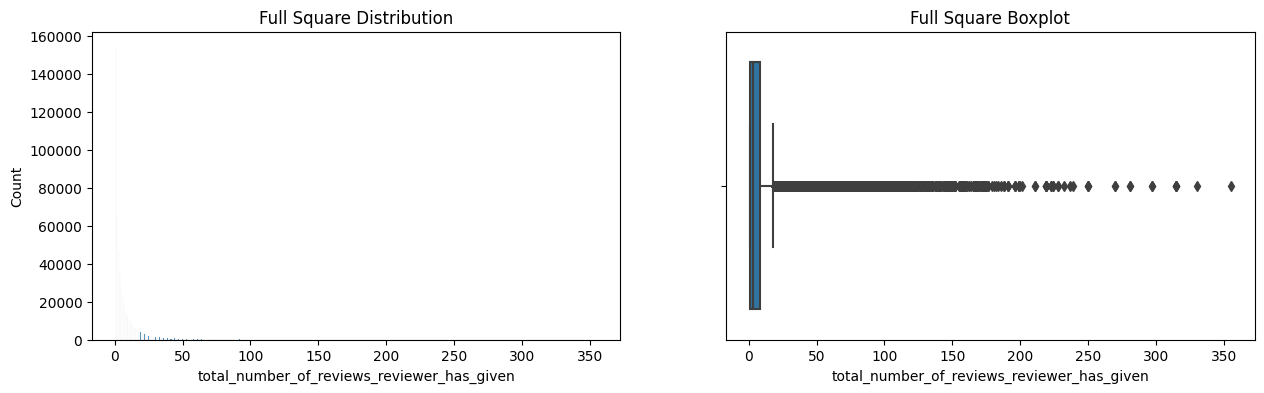

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', ax=axes[0])
histplot.set_title('Full Square Distribution')
boxplot = sns.boxplot(data=data, x='total_number_of_reviews_reviewer_has_given',ax=axes[1])
boxplot.set_title('Full Square Boxplot')

В курсе такие картинки показывали как пример распределений с выбросами. По-моему, для описываемой ситуации вполне ожидаемое логнормальное распределение. Может оценки супер-ревизоров с большим числом обзоров и вовсе внесут больший вклад в предсказания модели? Не буду ничего удалять

In [72]:
#Закомментировал, чтобы проверяющий не ждал прогона кода.
'''# Воспользуемся удобными библиотеками для анализа признаков.

from ydata_profiling import ProfileReport
import sweetviz as sv
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_file("your_report.html")

report = sv.analyze(data)
report.show_html()'''

'# Воспользуемся удобными библиотеками для анализа признаков.\n\nfrom ydata_profiling import ProfileReport\nimport sweetviz as sv\nprofile = ProfileReport(data, title="Pandas Profiling Report")\nprofile.to_file("your_report.html")\n\nreport = sv.analyze(data)\nreport.show_html()'

По отчётам вспомогательных инструментов - данные не содержат грубых выбросов.

#### Обнаружение неинформативных и нерелевантных признаков

In [73]:
# Проверим признаки на информативность по алгоритму из курса
low_information_cols = [] 
#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
if len(low_information_cols) == 0:
    print ("Нет неинформативных признаков")

Нет неинформативных признаков


Среди остальных признаков, reviewer_nationality оставляет впечатление нерелевантного. Можно попробовать разбить топ значений на dummies, но не хочу утяжелять модель.            

In [74]:
data.drop('reviewer_nationality', axis=1, inplace=True)

In [75]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
dtype: int64

# Проектирование признаков

Идеи:
* Преобразовать в числовые признаки review_date и days_after_review
* Создать числовой признак из текстов отзывов
* Поискать взаимосвязь оценки с тэгами

#### Создание признаков

In [76]:
# В ходе работы становится понятным, что больше всего оценка определяется содержанием столбцов
# с положительным и отрицательным отзывом. Я бы предпочел не пользоваться непройденными библиотеками,
# но они значительно повышают скор решения, так что применю хоть одну.

'''
%pip install afinn
from afinn import Afinn
afinn = Afinn()

data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No Negative', ''))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', ''))

data['neg_afinn_score'] = data['negative_review'].apply(lambda x: afinn.score(x))
data['pos_afinn_score'] = data['positive_review'].apply(lambda x: afinn.score(x))'''

"\n%pip install afinn\nfrom afinn import Afinn\nafinn = Afinn()\n\ndata['negative_review'] = data['negative_review'].apply(\n    lambda x: x.replace('No Negative', ''))\ndata['positive_review'] = data['positive_review'].apply(\n    lambda x: x.replace('No Positive', ''))\n\ndata['neg_afinn_score'] = data['negative_review'].apply(lambda x: afinn.score(x))\ndata['pos_afinn_score'] = data['positive_review'].apply(lambda x: afinn.score(x))"

Моя же самостоятельная идея для работы с текстовыми признаками: рассмотреть отдельно отзывы на 10 и 0 и ожидать от похожих отзывов похожих оценок

In [77]:
best_scores = data[data['reviewer_score'] == 10]
worst_scores = data[data['reviewer_score'] <= 3]

In [78]:
# Отзывы сравниваются с эталонно хорошими и плохими отзывами

def change_score(score, param, change):
    ''' Функция принимает столбец score, который нужно изменить,
                          столбец param, значения в котором проверяются на наличие в эталонном списке и
                          значение change, на которое меняются значения score
                        '''
    global lst
    if param in lst:
        score += change
    return score 

data['like_best'] = 0
data['like_worst'] = 0

lst = best_scores['negative_review'].value_counts()[:100].index #позитив в негативных отзывах
data['like_best'] = data.apply(lambda x: change_score(x['like_best'], x['negative_review'], 1), axis = 1)

lst = best_scores['positive_review'].value_counts()[:100].index #позитив в положительных отзывах
data['like_best'] = data.apply(lambda x: change_score(x['like_best'], x['positive_review'], 1), axis = 1)

#В отзывы группы worst_scores попадают нейтральные описания. В дополнительных строчках это решается. 
srs = worst_scores['positive_review'].value_counts()[:100] # негатив в положительных отзывах.
srs[srs > 9]
lst = list(srs.index) 
lst = [s for s in lst if 'oca' not in s] 
data['like_worst'] = data.apply(lambda x: change_score(x['like_worst'], x['positive_review'], -1), axis = 1)

srs = worst_scores['negative_review'].value_counts()[:100] # негатив в отрицательных отзывах
srs[srs > 9]
lst = list(srs.index)
lst = [s for s in lst if 'ver' in s]
data['like_worst'] = data.apply(lambda x: change_score(x['like_worst'], x['negative_review'], -1), axis = 1)

In [79]:
# Аналогично определяем теги уникальные для хороших и плохих отзывов и оцениваем по ним.
from collections import Counter
tag_list = {}
for i in best_scores['tags']:
    tags = re.findall(r"' ([^']*) '", i)
    for tag in tags:
        if tag not in tag_list:
            tag_list.update({tag:1})
        else:
            tag_list[tag]+=1
cnt1 = Counter(tag_list)
tag_set1 = set([x[0] for x in cnt1.most_common(50)])

tag_list = {}
for i in worst_scores['tags']:
    tags = re.findall(r"' ([^']*) '", i)
    for tag in tags:
        if tag not in tag_list:
            tag_list.update({tag:1})
        else:
            tag_list[tag]+=1
cnt2 = Counter(tag_list)
tag_set2 = set([x[0] for x in cnt2.most_common(50)])

def tag_score(score, param):
    global best_tags, worst_tags
    tags = re.findall(r"' ([^']*) '", param)
    for tag in tags:
        #if tag in best_tags: В процессе оптимизации по скору принято рещение оставить только похожесть тэгов на теги плохих отзывов
            #score+=1
        if tag in worst_tags:
            score-=1
    return score
best_tags = tag_set1.difference(tag_set2)
worst_tags = tag_set2.difference(tag_set1)

data['tags_like_worst'] = 0 

data['tags_like_worst'] = data.apply(lambda x: tag_score(x['tags_like_worst'], x['tags']), axis = 1)

In [80]:
# Получим численный признак популярности отеля (числа отзывов) из текстового названия отеля
hotel_ranks = dict(data['hotel_name'].value_counts().rank(ascending= False))
data['popularity'] = data['hotel_name'].apply(lambda x: hotel_ranks[x])

In [81]:
# Признак числа ночей в отеле
def find_stay(x):
    x = x.split("'")
    for i in x:
        if 'night' in i:
            try:
                return int(i.split(' ')[2])
            except:
                return 1
    return 1
        
data['stay'] = data['tags'].apply(find_stay)


In [82]:
# Достанем признак страны из адреса
data['country'] = data['hotel_address'].apply(lambda x: " ".join(x.split(' ')[-2::]) if x.split(' ')[-1]=='Kingdom' else x.split(' ')[-1])
data.drop(['hotel_address'], axis = 1, inplace = True)
data = pd.get_dummies(data, columns = ['country'])

#### Преобразование признаков

In [83]:
# Переводим признак "дней после отзыва" в число
data['int_days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
data['int_days_since_review'].value_counts()

1      2584
322    2304
120    2284
338    1959
534    1939
       ... 
327     199
615     194
122     192
124     173
123     142
Name: int_days_since_review, Length: 731, dtype: int64

In [84]:
# Делаем численный признак из даты отзыва. Признак выглядит некрасиво и сильно коррелирует с предыдущим, но, вроде, работает лучше
data['review_date'] = pd.to_datetime(data['review_date'])
#перевод даты формата 1999-12-22 в число 19991222
data['review_date'] = data['review_date'].apply(lambda x: int(x.strftime('%Y%m%d')))

#### Отбор признаков

In [85]:
# Удаляем колонки типа object
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   like_best                                   515431 non-null  int64  
 

In [86]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
col_names = list(data.columns)
data_mm = mm_scaler.fit_transform(data)
data_mm = pd.DataFrame(data_mm, columns=col_names)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(data_mm)
df_s = pd.DataFrame(df_s, columns=col_names)

In [87]:
df_s['sample'] = data['sample']
df_s['reviewer_score'] = data['reviewer_score']

In [88]:
df_s

,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,like_best,...,tags_like_worst,popularity,stay,country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,int_days_since_review
0,0.810447,1.323376,-0.543087,1.126951,6.008116,2.028266,-0.558508,0,0.0,-0.822534,...,0.109745,-0.949617,-0.219444,-0.285863,-0.361683,3.585169,-0.353352,-0.363475,-1.017950,-1.634183
1,0.227169,-0.098908,0.369267,-0.287622,0.980982,-0.815355,-0.014967,0,0.0,1.071208,...,0.109745,-0.743912,-0.826653,-0.285863,-0.361683,-0.278927,2.830043,-0.363475,-1.017950,-0.576337
2,-0.903433,-1.607495,-0.178145,-0.523384,-1.032547,-0.586031,0.709754,0,0.0,-0.822534,...,0.109745,2.545880,-0.826653,-0.285863,-0.361683,-0.278927,-0.353352,2.751225,-1.017950,1.252157
3,-0.513914,-1.623799,1.281621,-0.624425,-0.518271,0.422996,0.166213,0,0.0,1.071208,...,0.109745,0.658759,-0.826653,-0.285863,-0.361683,3.585169,-0.353352,-0.363475,-1.017950,1.443622
4,0.670620,-0.203010,1.281621,-0.624425,0.838175,-0.494301,-0.467917,0,0.0,1.071208,...,0.109745,-0.940673,-0.219444,-0.285863,-0.361683,-0.278927,2.830043,-0.363475,-1.017950,0.428856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515426,-0.781583,1.278205,1.099150,-0.624425,-0.917784,-0.356707,0.256804,1,8.8,1.071208,...,0.109745,0.636400,-0.219444,-0.285863,-0.361683,-0.278927,-0.353352,-0.363475,0.982366,-1.189026
515427,-0.451991,1.247393,0.004325,-0.624425,0.206979,3.450077,-0.558508,1,9.2,1.071208,...,0.109745,0.125118,0.994973,3.498174,-0.361683,-0.278927,-0.353352,-0.363475,-1.017950,-0.877895
515428,-0.082448,-0.249228,-2.915208,-0.220261,0.002908,-0.402572,1.253295,1,8.3,-0.822534,...,0.109745,-0.851236,-0.826653,-0.285863,-0.361683,-0.278927,-0.353352,-0.363475,0.982366,0.902733
515429,-0.266221,1.293461,-0.543087,-0.624425,-0.507916,-0.540166,1.887426,1,9.2,1.071208,...,0.109745,-0.244555,-0.219444,-0.285863,-0.361683,-0.278927,-0.353352,-0.363475,0.982366,-1.342198


<AxesSubplot: >

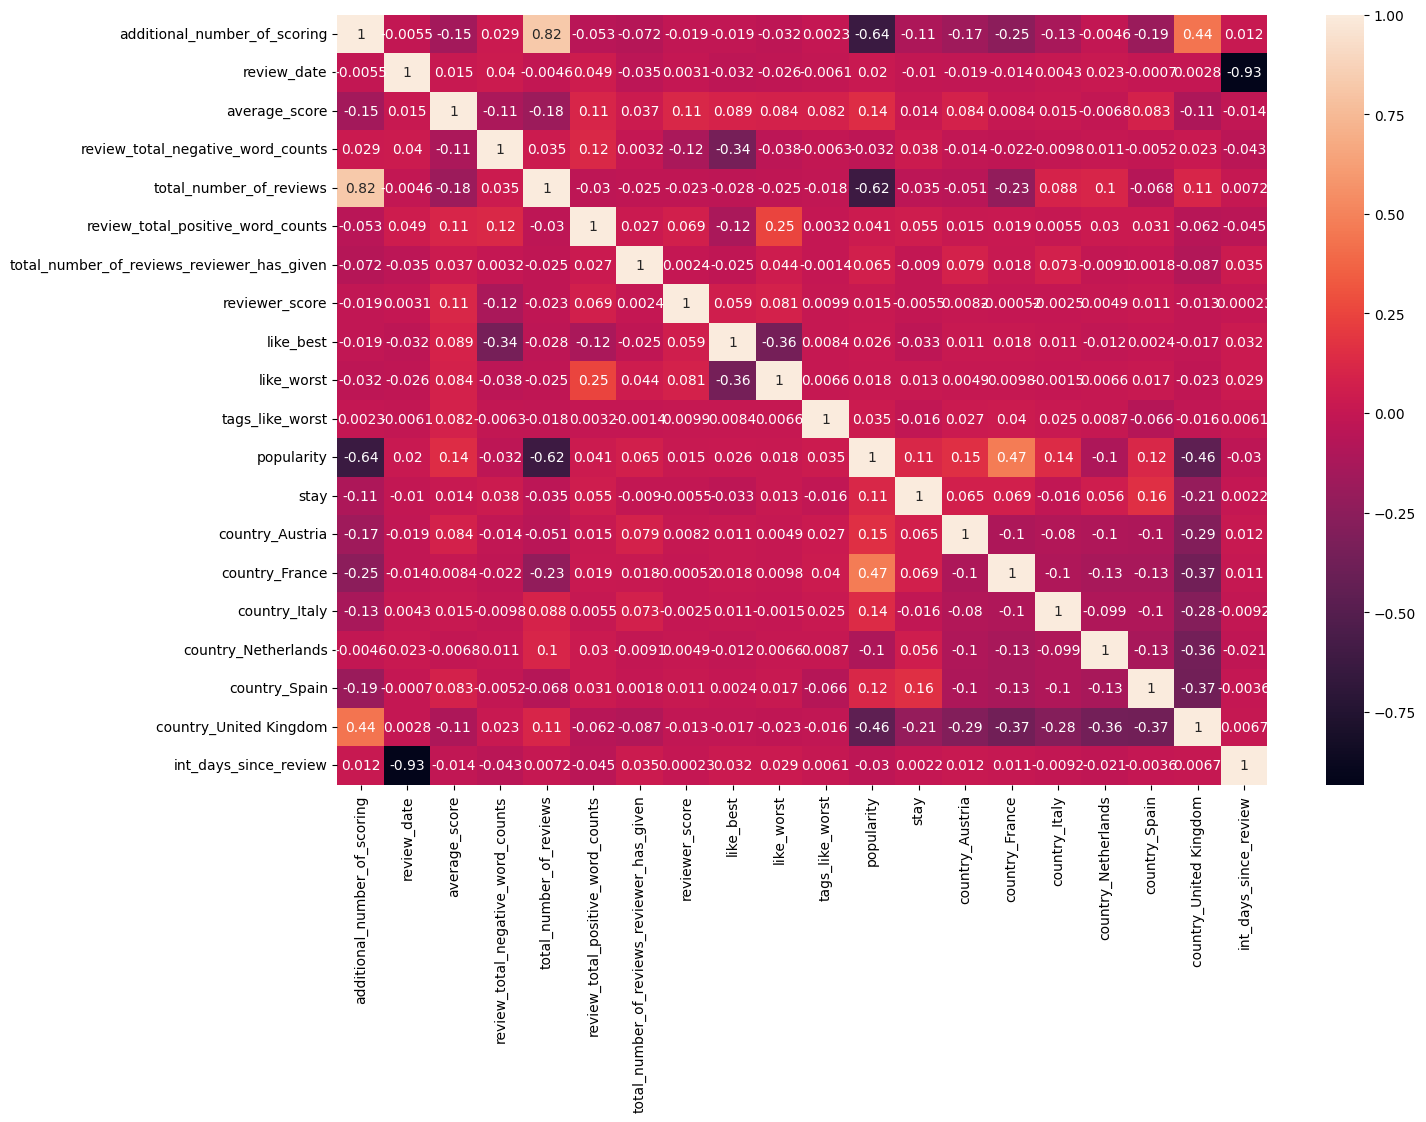

In [89]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_s.drop(['sample'], axis=1).corr(), annot=True)


Остались две сильно коррелированные пары признаков, но их правка заметно бьёт по скору, так что не трогаю их.

# Cобственно моделирование (код Baseline)

In [90]:
# Теперь выделим тестовую часть
train_data = df_s.query('sample == 1').drop(['sample'], axis=1)
test_data = df_s.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [91]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [92]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 20), (386496, 20), (386496, 19), (309196, 19), (77300, 19))

In [93]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [94]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [95]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.8s finished


In [96]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.936169545493747


<AxesSubplot: >

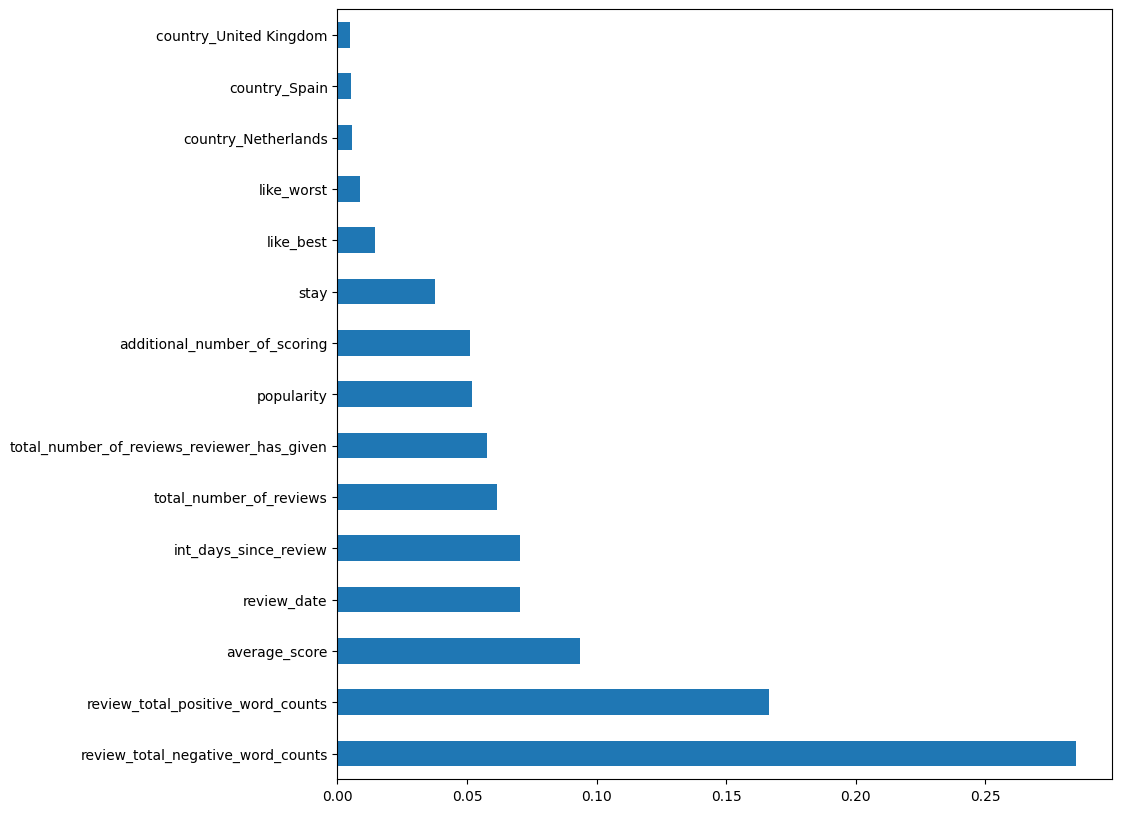

In [97]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [98]:
test_data.sample(10)
test_data = test_data.drop(['reviewer_score'], axis=1)
sample_submission

,reviewer_score,id
0,8.817,488440
1,6.734,274649
2,8.246,374688
3,9.293,404352
4,9.765,451596
...,...,...
128930,8.988,495812
128931,8.746,315577
128932,7.899,511968
128933,9.682,303386


In [99]:
predict_submission = model.predict(test_data)
predict_submission
list(sample_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


['reviewer_score', 'id']

In [100]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.817,488440
1,6.734,274649
2,8.246,374688
3,9.293,404352
4,9.765,451596
5,8.489,302161
6,8.353,317079
7,7.829,13963
8,8.758,159785
9,8.016,195089
